
* **Interactive 3D Protein Visualization and Statistical Comparison of B-factors between Secondary Strucrures:**

    * **Downloading and parsing protein structure files (PDB format).**

    * **Interactive 3D rendering of protein structures using NGLView.**

    * **Extraction and 2D visualization of structural properties like B-factors (flexibility) using Matplotlib and Seaborn.**

    * **Statistical comparison of B-factors across different secondary structure elements.**
 
Chandana Kodiweera, Ph.D.


In [1]:
import requests
import os
import nglview as nv
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.PDB import PDBList, PDBParser
from scipy import stats


In [2]:
# Downlaod a pdb protien file
# example protien ids : 1CRN (Crambin), 1UBQ (Ubiquitin), 4HHB (Hemoglogin,  a larger protien), 2J58, 6RDE, 1GFP (Green Fluorescent Protein (GFP))
# 2WTM (Human Tropomyosin)
PDB_ID = "4HHB" 
PDB_DOWNLOAD_URL = f"https://files.rcsb.org/download/{PDB_ID}.pdb"
OUTPUT_DIR = "data" # in this example, output directory is in the current directory
PDB_FILE_PATH = os.path.join(OUTPUT_DIR, f"{PDB_ID}.pdb")


In [3]:
print(PDB_DOWNLOAD_URL)

https://files.rcsb.org/download/4HHB.pdb


In [4]:
# Dowonload the protien file using request
# Assuming the file do exist. Error handling must be implementing in case the file doesn't exist.

response = requests.get(PDB_DOWNLOAD_URL)
with open(PDB_FILE_PATH, 'wb') as f:
        f.write(response.content)


In [5]:
# Visualize the Protein in 3D using NGLView ---

view = nv.show_structure_file(PDB_FILE_PATH)
view.background = 'white'
view.add_representation('cartoon', selection='protein', color='s_ss')
view.camera = 'perspective'
display(view)

print(f"\nInteractive 3D protein visualization of {PDB_ID}.")
print("You can rotate, zoom, and pan the protein in the viewer.")
print("Try clicking on different parts of the protein to select residues.")

NGLWidget()


Interactive 3D protein visualization of 4HHB.
You can rotate, zoom, and pan the protein in the viewer.
Try clicking on different parts of the protein to select residues.


In [6]:
# Secondary Structure Assignment (from PDB records)


helix_ranges = {} # {chain_id: [(start_res_num, end_res_num), ...]} will gather for all the subunits
sheet_ranges = {} # {chain_id: [(start_res_num, end_res_num), ...]} will gather for all the subunits

with open(PDB_FILE_PATH, 'r') as f:
    for line in f:
        if line.startswith('HELIX'):
            chain_id = line[19]  # The PDB format specification for a HELIX record defines that the initChainID (chain identifier for the initial residue of the helix) is located in column 20.
            start_res_num = int(line[21:25])
            end_res_num = int(line[33:37])
            if chain_id not in helix_ranges:
                helix_ranges[chain_id] = []
            helix_ranges[chain_id].append((start_res_num, end_res_num))
        elif line.startswith('SHEET'):
            chain_id = line[21]
            start_res_num = int(line[22:26])
            end_res_num = int(line[33:37])
            if chain_id not in sheet_ranges:
                sheet_ranges[chain_id] = []
            sheet_ranges[chain_id].append((start_res_num, end_res_num))

In [7]:
#Function to determine secondary structure for a given residue
def get_ss_type(chain_id, res_num):
    # Check for Helix
    if chain_id in helix_ranges:
        for start, end in helix_ranges[chain_id]:
            if start <= res_num <= end:
                return 'Alpha-Helix'
    # Check for Sheet
    if chain_id in sheet_ranges:
        for start, end in sheet_ranges[chain_id]:
            if start <= res_num <= end:
                return 'Beta-Sheet'
    return 'Coil/Loop' # Default if not in helix or sheet

In [8]:
# PDB parser to extract structural information from the PDB file.
parser = PDBParser() 

structure = parser.get_structure(PDB_ID, PDB_FILE_PATH)
structure

C:\Users\kodiw\miniconda3\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5273.
  warnings.warn(
C:\Users\kodiw\miniconda3\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5316.
  warnings.warn(
C:\Users\kodiw\miniconda3\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5360.
  warnings.warn(
C:\Users\kodiw\miniconda3\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5403.
  warnings.warn(
C:\Users\kodiw\miniconda3\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5447.
  warnings.warn(
C:\Users\kodiw\miniconda3\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5503.
  warnings.warn(
C:\U

<Structure id=4HHB>

In [9]:
b_factors = []
residue_numbers = []
residue_names = []
chain_ids = []
secondary_structures = [] # Alpha Helix, Beta Sheet


# Iterate through all atoms in the structure to get B-factors and assign SS
for model in structure:
    for chain in model:
        for residue in chain:
            # Skip heteroatoms (e.g., HETATM records like water, ligands)
            if residue.get_id()[0] != ' ':
                continue

            res_num = residue.get_id()[1]
            chain_id = chain.get_id()

            ca_atom = None
            for atom in residue:
                if atom.get_id() == 'CA':
                    ca_atom = atom
                    break
                
            if ca_atom:
                b_factors.append(ca_atom.get_bfactor())
                residue_numbers.append(res_num)
                residue_names.append(residue.get_resname())
                chain_ids.append(chain_id)
                secondary_structures.append(get_ss_type(chain_id, res_num))
            else:
                # If no CA atom, average all atom B-factors for the residue
                residue_b_factors = [atom.get_bfactor() for atom in residue if atom.get_bfactor() is not None]
                if residue_b_factors:
                    b_factors.append(np.mean(residue_b_factors))
                    residue_numbers.append(res_num)
                    residue_names.append(residue.get_resname())
                    chain_ids.append(chain_id)
                    secondary_structures.append(get_ss_type(chain_id, res_num))
                    # else: skip residue if no B-factor data at all


In [10]:
# Create a DataFrame for 2D plotting
b_factor_df = pd.DataFrame({
    'Residue_Number': residue_numbers,
    'Residue_Name': residue_names,
    'Chain_ID': chain_ids,
    'B_Factor': b_factors,
    'Secondary_Structure': secondary_structures
})


In [11]:
# Drop any rows where B_Factor might be NaN or Inf (if a residue had no atoms with B-factors)
b_factor_df.dropna(subset=['B_Factor'], inplace=True)

b_factor_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [12]:
b_factor_df.isin([np.inf, -np.inf]).sum()

Residue_Number         0
Residue_Name           0
Chain_ID               0
B_Factor               0
Secondary_Structure    0
dtype: int64

In [13]:
print(f"Extracted B-factor data for {len(b_factor_df)} residues.")
print("\n--- B-factor Data Snippet (with Secondary Structure) ---")
print(b_factor_df.head())
print("\n--- Secondary Structure Counts ---")
print(b_factor_df['Secondary_Structure'].value_counts())

Extracted B-factor data for 574 residues.

--- B-factor Data Snippet (with Secondary Structure) ---
   Residue_Number Residue_Name Chain_ID  B_Factor Secondary_Structure
0               1          VAL        A     43.14           Coil/Loop
1               2          LEU        A     26.32           Coil/Loop
2               3          SER        A     26.03         Alpha-Helix
3               4          PRO        A     38.81         Alpha-Helix
4               5          ALA        A     24.06         Alpha-Helix

--- Secondary Structure Counts ---
Secondary_Structure
Alpha-Helix    448
Coil/Loop      126
Name: count, dtype: int64


C:\Users\kodiw\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kodiw\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kodiw\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kodiw\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a le

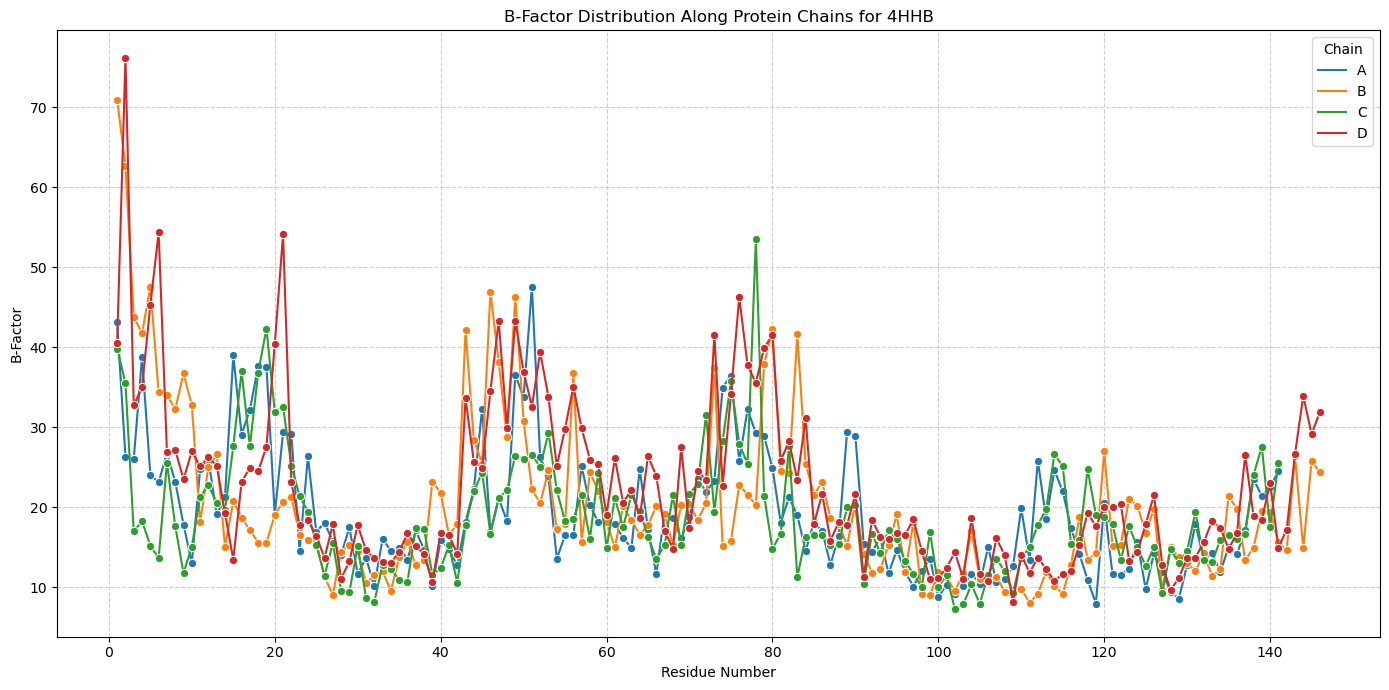

C:\Users\kodiw\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


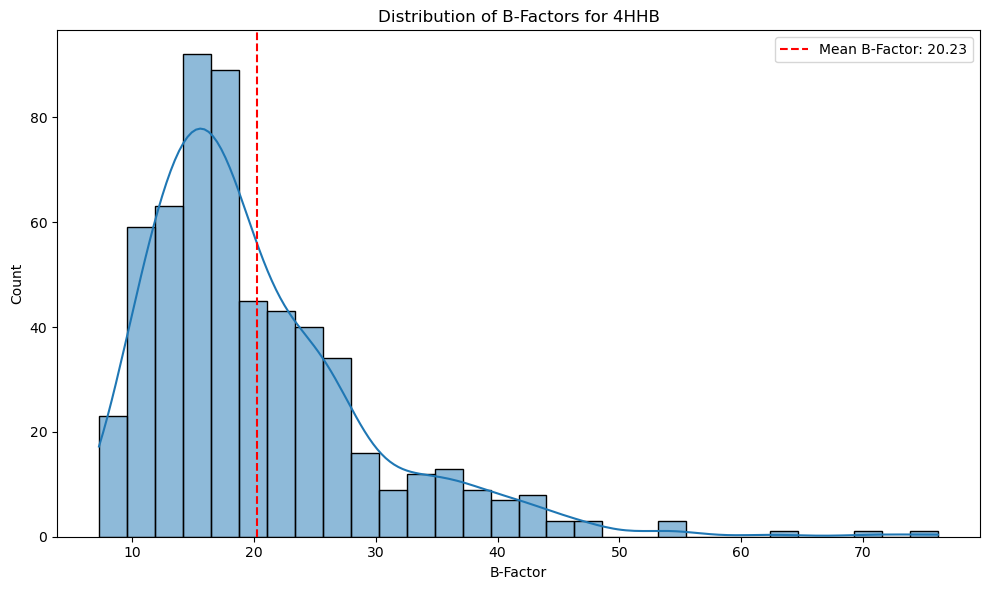

In [14]:
# Create 2D Plots using Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=b_factor_df, x='Residue_Number', y='B_Factor', hue='Chain_ID', marker='o', errorbar=None)
plt.title(f'B-Factor Distribution Along Protein Chains for {PDB_ID}')
plt.xlabel('Residue Number')
plt.ylabel('B-Factor')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Chain')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(b_factor_df['B_Factor'], bins=30, kde=True)
plt.title(f'Distribution of B-Factors for {PDB_ID}')
plt.xlabel('B-Factor')
plt.ylabel('Count')
plt.axvline(b_factor_df['B_Factor'].mean(), color='red', linestyle='--', label=f'Mean B-Factor: {b_factor_df["B_Factor"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

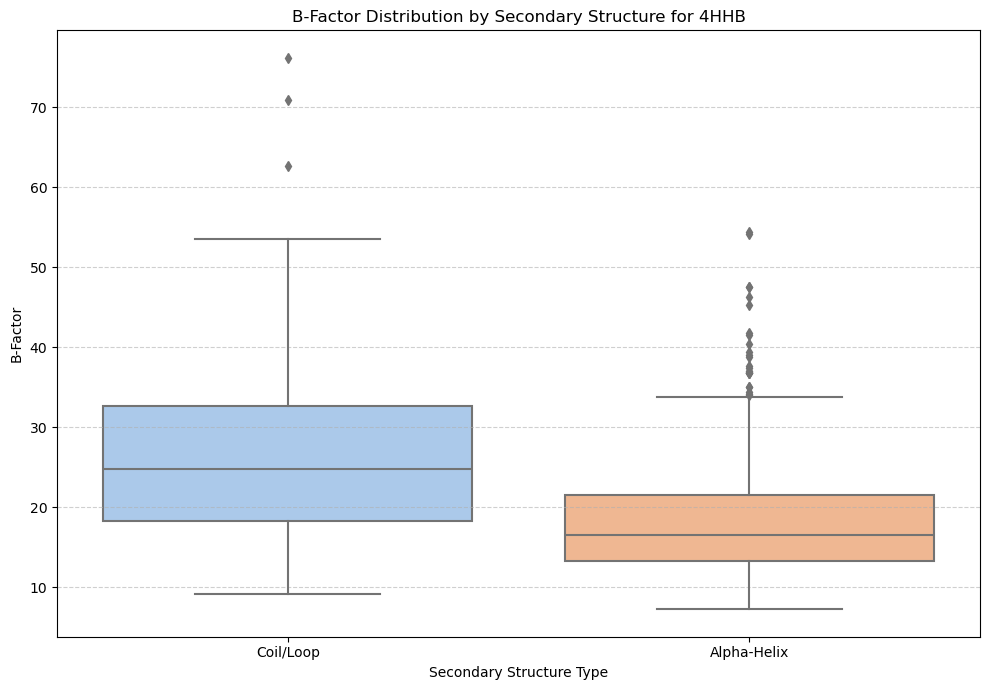

In [15]:
# New Plot: Box plot/Violin plot comparing B-factors by Secondary Structure
plt.figure(figsize=(10, 7))
sns.boxplot(data=b_factor_df, x='Secondary_Structure', y='B_Factor', palette='pastel')
plt.title(f'B-Factor Distribution by Secondary Structure for {PDB_ID}')
plt.xlabel('Secondary Structure Type')
plt.ylabel('B-Factor')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [16]:
# Perform Statistical Tests (e.g., Independent Samples T-test)
    
# B-factors for each secondary structure type
   
helices_bf = b_factor_df[b_factor_df['Secondary_Structure'] == 'Alpha-Helix']['B_Factor']
sheets_bf = b_factor_df[b_factor_df['Secondary_Structure'] == 'Beta-Sheet']['B_Factor']
coils_bf = b_factor_df[b_factor_df['Secondary_Structure'] == 'Coil/Loop']['B_Factor']

# Perform t-tests if enough data points exist in each group
min_samples = 2 # Need at least 2 samples for t-test

if len(helices_bf) >= min_samples and len(sheets_bf) >= min_samples:
    t_stat_hs, p_value_hs = stats.ttest_ind(helices_bf, sheets_bf, equal_var=False) # Welch's t-test
    print(f"Alpha-Helix vs. Beta-Sheet: T-statistic = {t_stat_hs:.2f}, P-value = {p_value_hs:.3f}")
    if p_value_hs < 0.05:
        print("  (Statistically significant difference in B-factors)")
    else:
        print("  (No statistically significant difference in B-factors)")

if len(helices_bf) >= min_samples and len(coils_bf) >= min_samples:
    t_stat_hc, p_value_hc = stats.ttest_ind(helices_bf, coils_bf, equal_var=False)
    print(f"Alpha-Helix vs. Coil/Loop: T-statistic = {t_stat_hc:.2f}, P-value = {p_value_hc:.3f}")
    if p_value_hc < 0.05:
        print("  (Statistically significant difference in B-factors)")
    else:
        print("  (No statistically significant difference in B-factors)")
            
if len(sheets_bf) >= min_samples and len(coils_bf) >= min_samples:
    t_stat_sc, p_value_sc = stats.ttest_ind(sheets_bf, coils_bf, equal_var=False)
    print(f"Beta-Sheet vs. Coil/Loop: T-statistic = {t_stat_sc:.2f}, P-value = {p_value_sc:.3f}")
    if p_value_sc < 0.05:
        print("  (Statistically significant difference in B-factors)")
    else:
        print("  (No statistically significant difference in B-factors)")

Alpha-Helix vs. Coil/Loop: T-statistic = -7.91, P-value = 0.000
  (Statistically significant difference in B-factors)
